In [35]:
import numpy as np
import matplotlib.pyplot as plt

def preprocess_data(neural_data):
    """
    Preprocess data by subtracting the mean firing rate for each neuron
    to reduce low-frequency components.
    """
    return neural_data - np.mean(neural_data, axis=1, keepdims=True)

def calculate_band_score(neural_data, angle_bins=36):
    """
    Calculate the band score for each neuron by performing a 2D Fourier
    transform on their place tuning maps and directly measuring concentration.
    
    Parameters:
    neural_data (numpy.ndarray): Matrix of size (N_g, T) where each row
                                 represents a neuron's firing rate over T timesteps.
    angle_bins (int): Number of angular bins to divide the frequency space.
    
    Returns:
    band_scores (list): A list of band scores for each neuron.
    """
    N_g, T = neural_data.shape
    band_scores = []
    
    bin_power = np.zeros([N_g,angle_bins])
    for i in range(N_g):
        # Assume each neuron has a 1D firing rate over time, so reshape to a 2D place map (e.g., 32x32 grid)
        grid_size = int(np.sqrt(T))
        neuron_map = neural_data[i].reshape((grid_size, grid_size))

        # Compute the 2D Fourier transform of the neuron's place tuning map
        fft_map = np.fft.fftshift(np.fft.fft2(neuron_map))
        fft_magnitude = np.abs(fft_map)

        # Ignore the DC component by setting the center frequency to zero
        fft_magnitude[grid_size // 2, grid_size // 2] = 0
        fft_magnitude[:, :grid_size // 2] = 0
        
        # Compute total power in the Fourier spectrum
        total_power = np.sum(fft_magnitude)
        
        # Calculate power concentration by dividing into angular bins
        y, x = np.indices((grid_size, grid_size)) - grid_size // 2
        angles = np.arctan2(y, x)  # Angle of each Fourier component
        for bin_index in range(angle_bins):
            # Calculate the angular range for the current bin, covering the full 2*pi
            bin_start = -np.pi + 2 * np.pi * bin_index / angle_bins
            bin_end = bin_start + 2 * np.pi / angle_bins
            
            # Mask for components within the current angular bin
            mask = (angles >= bin_start) & (angles < bin_end)
            bin_power[i, bin_index] = np.sum(fft_magnitude[mask])

        max_bin_power = np.max(bin_power[i,:int(angle_bins/2)])
        total_power = np.sum(bin_power[i,:int(angle_bins/2)])
        
        # Band score as concentration ratio: maximum bin power / total power
        band_score = max_bin_power / (total_power + 1e-8)  # normalize by total power
        band_scores.append(band_score)
        
    return band_scores,bin_power

def plot_band_scores(band_scores):
    """
    Plot histogram of band scores to visualize the distribution.
    """
    plt.figure(figsize=(8, 5))
    plt.hist(band_scores, bins=20, color='skyblue', edgecolor='black')
    plt.title("Distribution of Band Scores")
    plt.xlabel("Band Score")
    plt.ylabel("Number of Neurons")
    plt.show()


Band Scores: [0.25348271559499463, 0.3104413486834186]
Band cells (neuron indices): [0, 1]


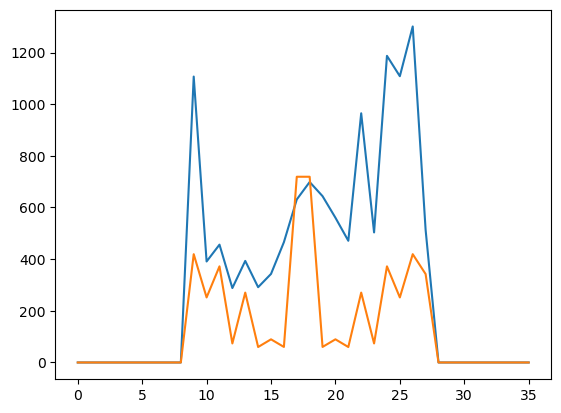

In [36]:

# Test Data Generation
L = 1.5
theta = np.pi / 3
res = 50
X, Y = np.meshgrid(np.linspace(-2, 2, res), np.linspace(-2, 2, res))
x_flat, y_flat = X.flatten(), Y.flatten()
loc = np.stack([x_flat, y_flat])

k = np.array([np.cos(theta), np.sin(theta)]) * np.pi * 2 / L
rate1 = np.cos(np.dot(k, loc))

theta_1 = 0
theta_2 = np.pi / 3
theta_3 = 2 * np.pi / 3
k1 = np.array([np.cos(theta_1), np.sin(theta_1)]) * np.pi * 2 / L
k2 = np.array([np.cos(theta_2), np.sin(theta_2)]) * np.pi * 2 / L
k3 = np.array([np.cos(theta_3), np.sin(theta_3)]) * np.pi * 2 / L

rate2 = np.cos(np.dot(k1, loc)) + np.cos(np.dot(k2, loc)) + np.cos(np.dot(k3, loc))
neural_data = np.stack([rate1, rate2 / 3])

# Step 1: Preprocess the data to subtract the mean firing rate
preprocessed_data = preprocess_data(neural_data)

# Step 2: Calculate the band scores
band_scores, bin_power = calculate_band_score(preprocessed_data)

# Step 3: Plot the band scores
# plot_band_scores(band_scores)
plt.plot(bin_power[0,:])
plt.plot(bin_power[1,:])
print("Band Scores:", band_scores)

# Step 4: Identify neurons with high band scores as band cells
band_threshold = 0.1  # Adjust threshold based on distribution
band_cells = [i for i, score in enumerate(band_scores) if score > band_threshold]
print(f"Band cells (neuron indices): {band_cells}")


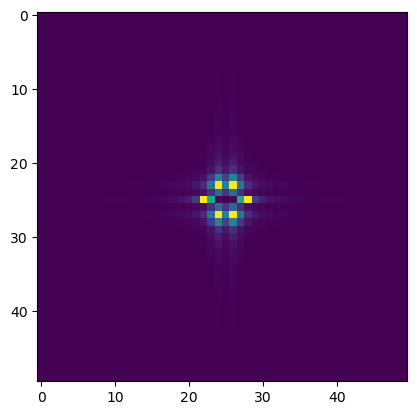

In [47]:

theta_1 = 0
theta_2 = np.pi / 3
theta_3 = 2 * np.pi / 3
k1 = np.array([np.cos(theta_1), np.sin(theta_1)]) * np.pi * 2 / L
k2 = np.array([np.cos(theta_2), np.sin(theta_2)]) * np.pi * 2 / L
k3 = np.array([np.cos(theta_3), np.sin(theta_3)]) * np.pi * 2 / L

rate2 = np.cos(np.dot(k1, loc)) + np.cos(np.dot(k2, loc)) + np.cos(np.dot(k3, loc))

T = loc.shape[1]
grid_size = int(np.sqrt(T))
neuron_map = rate2.reshape((grid_size, grid_size))

# Compute the 2D Fourier transform of the neuron's place tuning map
fft_map = np.fft.fftshift(np.fft.fft2(neuron_map))
fft_magnitude = np.abs(fft_map)

# Ignore the DC component by setting the center frequency to zero
fft_magnitude[grid_size // 2, grid_size // 2] = 0
# fft_magnitude[:, :grid_size // 2] = 0
plt.imshow(fft_magnitude)


-3.1016139664665032


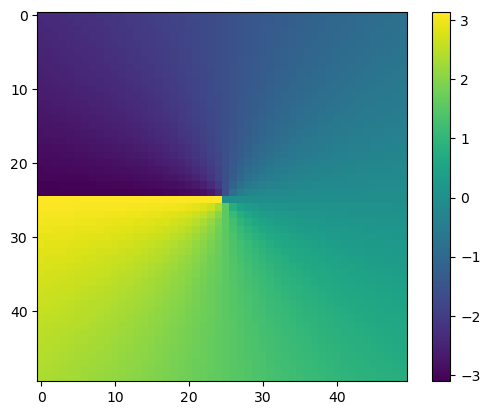

In [48]:

y, x = np.indices((grid_size, grid_size)) - grid_size // 2
angle_bins = 100
angles = np.arctan2(y, x)  # Angle of each Fourier component
print(np.min(angles))
plt.imshow(angles)
plt.colorbar()


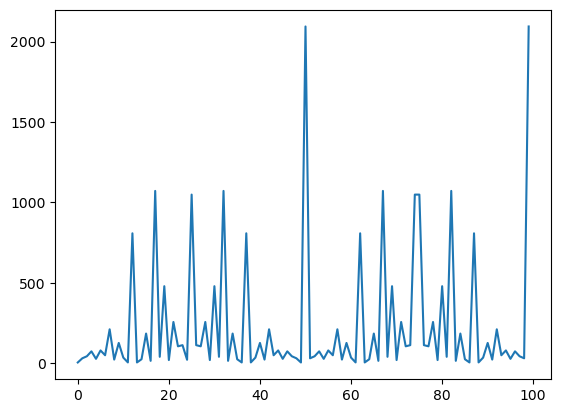

In [49]:

bin_power = np.zeros(angle_bins)
for bin_index in range(angle_bins):
    # Calculate the angular range for the current bin, covering the full 2*pi
    bin_start = -np.pi + 2 * np.pi * bin_index / angle_bins
    bin_end = bin_start + 2 * np.pi / angle_bins
    
    # Mask for components within the current angular bin
    mask = (angles >= bin_start) & (angles < bin_end)
    bin_power[bin_index] = np.sum(fft_magnitude[mask])
plt.plot(bin_power)